In [1]:
# installs
!pip install ultralytics
!pip install supervision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 882.5/882.5 kB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 kB 12.2 MB/s eta 0:00:00


In [17]:
!pwd
!ls ../content/data/
#/content/data/I94-US20-35.4.mp4

/content
I94-US20-35.4.mp4


In [83]:
import supervision as sv
# Configuration
CAMERA_ID = "I94-US20-35"
#CAMERA_ID =  I65-53-1
#CAMERA_ID =  I65-53-2
VIDEO_ID = 1 # 1 - 4

# settings for counting line
# I94-US20-35
LINE_START = sv.Point(350, 1000)
LINE_END = sv.Point(1400, 600)
# I65-53-1
#LINE_START = sv.Point(350, 1000)
#LINE_END = sv.Point(1400, 600)
# I65-53-1
#LINE_START = sv.Point(350, 1000)
#LINE_END = sv.Point(1400, 600)

SOURCE_VIDEO_PATH = f"../content/data/{CAMERA_ID}.{VIDEO_ID}.mp4"
TARGET_VIDEO_PATH = f'../content/demo/results.{CAMERA_ID}.{VIDEO_ID}.mp4'

# class_ids of interest : car, motorcycle, and truck
selected_classes = [2, 3, 7]

# get video info
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

# MPH_CONVERSION_FACTOR = (feet/frame) * (frames/second) * (seconds/minute) * (minutes/hour) * (mile/feet)
MPH_CONVERSION_FACTOR = 30 * 60 * 60 / 5280

# # Predefined common colors and their RGB values
# COLOR_NAMES = {
#     (255, 0, 0): 'Red',
#     (0, 255, 0): 'Green',
#     (0, 0, 255): 'Blue',
#     (255, 255, 0): 'Yellow',
#     (255, 165, 0): 'Orange',
#     (255, 255, 255): 'White',
#     (0, 0, 0): 'Black',
#     (128, 128, 128): 'Gray',
# }


In [84]:
# import YOLO and create model
import numpy as np
import cv2
from ultralytics import YOLO

# load YOLOv8 segmentation model
model = YOLO('yolov8x.pt')

# dict mapping class_id to class_name
CLASS_NAMES_DICT = model.model.names

# video and processing settings
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
print(video_info)
frame_rate = video_info.fps
pixel_to_feet_ratio = 0.3287979746107146  # adjust this based on estimated ratio

# storing previous vehicle positions for computations
previous_positions = {}
# Initialize a dictionary to store the previous speed and smoothed speed values
smoothed_speeds = {}

# create bytetracker instance
# defaults track_thresh=0.25, track_buffer=30, match_thresh=0.8, frame_rate=30)
byte_tracker = sv.ByteTrack(frame_rate=29, minimum_consecutive_frames=2)

# create videoInfo instance
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

# create frame generator
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# create LineZone instance
line_zone = sv.LineZone(start=LINE_START, end=LINE_END)

# create LineZoneAnnotator instance
line_zone_annotator = sv.LineZoneAnnotator(thickness=4, text_thickness=4, text_scale=2)

# create LabelAnnotator instance
label_annotator = sv.LabelAnnotator()

# BoxAnnotator
box_annotator = sv.BoxAnnotator()

# DotAnnotator
dot_annotator = sv.DotAnnotator()


# dict mapping class_id to class_name
CLASS_NAMES_DICT = model.model.names

# class_ids of interest : car, motorcycle, and truck
selected_classes = [2, 3, 7]


VideoInfo(width=1920, height=1080, fps=29, total_frames=829)


In [85]:
# Matt
import numpy as np
from collections import deque

# Initialize a deque to store the last N speed values for each vehicle
speed_history = {}

# Number of frames to average over
SPEED_SMOOTHING_FRAMES = 5

# Function to calculate the smoothed speed
def get_smoothed_speed(tracker_id, new_speed):
    if tracker_id not in speed_history:
        speed_history[tracker_id] = deque(maxlen=SPEED_SMOOTHING_FRAMES)

    # Append the new speed to the deque (removes the oldest value if full)
    speed_history[tracker_id].append(new_speed)

    # Calculate the smoothed speed as the average of the last N speed values
    smoothed_speed = np.mean(speed_history[tracker_id])

    return smoothed_speed

# Assume we have a horizon y-coordinate
HORIZON_Y = 300  # Y-coordinate of the horizon (adjust for your video)

# Nonlinear perspective scaling factor function (logarithmic adjustment)
def get_perspective_scale(y_center, image_height):
    # Vehicles near the horizon should have a smaller scale factor
    # The closer a vehicle is to the bottom, the higher the scale factor
    distance_from_horizon = max(y_center - HORIZON_Y, 1)  # Prevent division by 0
    max_distance = image_height - HORIZON_Y

    # Nonlinear scaling using logarithmic adjustment
    scale_factor = 1 + np.log(max_distance / distance_from_horizon)
    return scale_factor

# Function to calculate speed in mph, with perspective scaling
def calculate_speed_mph(prev_position, curr_position, time_delta, pixel_to_feet_ratio, y_center, image_height):
    # Calculate the Euclidean distance between the previous and current position in pixels
    pixel_distance = np.linalg.norm(np.array(curr_position) - np.array(prev_position))

    # Apply the perspective scaling based on the vehicle's distance from the horizon
    perspective_scale = get_perspective_scale(y_center, image_height)
    scaled_pixel_distance = pixel_distance * perspective_scale

    # Convert the scaled pixel distance to real-world distance (feet)
    real_distance_feet = scaled_pixel_distance * pixel_to_feet_ratio

    # Speed in feet per second
    speed_fps = real_distance_feet / time_delta

    # Convert feet per second to mph (1 fps = 0.681818 mph)
    speed_mph = speed_fps * 0.681818

    return speed_mph


In [86]:
# Yash

# Define known colors and their ranges (in BGR format)
color_ranges = {
    'Red': ([0, 0, 100], [80, 80, 255]),
    'Blue': ([100, 0, 0], [255, 80, 80]),
    'White': ([200, 200, 200], [255, 255, 255]),
    'Black': ([0, 0, 0], [140, 140, 140]),
    'Gray': ([150, 150, 150], [190, 190, 190])
}

def get_dominant_color(image):
    # Convert the image to the HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Focus on a central region of the bounding box to avoid background colors
    h, w, _ = image.shape
    center_h, center_w = h // 4, w // 4  # Use the central quarter of the bounding box
    center_region = image[center_h:h-center_h, center_w:w-center_w]

    # Calculate the mean color of the center region
    average_color = np.mean(center_region, axis=(0, 1))  # Get the mean color in the BGR space
    b, g, r = average_color

    # Check the color ranges to match with a predefined color
    detected_color = 'Unknown'

    for color_name, (lower, upper) in color_ranges.items():
        lower = np.array(lower, dtype=np.uint8)
        upper = np.array(upper, dtype=np.uint8)

        # Count how many channels (B, G, R) fall within the range
        matches = sum([lower[0] <= b <= upper[0],  # Check if blue is in range
                       lower[1] <= g <= upper[1],  # Check if green is in range
                       lower[2] <= r <= upper[2]])  # Check if red is in range

        # If at least 2 out of 3 components (B, G, or R) match, assign the color
        if matches >= 2:
            detected_color = color_name
            break

    return detected_color

In [87]:
import numpy as np
import cv2
from collections import deque

def democallback(frame: np.ndarray, index: int) -> np.ndarray:
    image_height, image_width = frame.shape[:2]  # Get the dimensions of the frame

    # Model prediction on a single frame and conversion to Supervision Detections
    results = model(frame, verbose=False)[0]

    # Convert YOLO results to Supervision Detections with bounding boxes
    detections = sv.Detections.from_ultralytics(results)

    # Track detections (vehicles) across frames using ByteTrack
    detections = byte_tracker.update_with_detections(detections)

    # Filter detections for the selected classes (e.g., 'car' and 'truck')
    detections = detections[np.isin(detections.class_id, selected_classes)]

    labels = []
    bboxes = []

    # Check if detections have bounding boxes
    if detections is not None and hasattr(detections, 'xyxy') and detections.xyxy is not None:

        # Process each tracked detection to calculate the bounding box center and detect color
        for bbox in detections.xyxy:
            bbox_center = None
            dominant_color = None
            color_name = None

            if bbox is not None and len(bbox) > 0:
                # Calculate the center of the bounding box (which will be the location of the dot)
                x_center = int((bbox[0] + bbox[2]) / 2)  # X center
                y_center = int((bbox[1] + bbox[3]) / 2)  # Y center
                bbox_center = (x_center, y_center)

                # Crop the bounding box area from the original frame
                x_min, y_min, x_max, y_max = map(int, bbox)  # Convert to integer values
                cropped_image = frame[y_min:y_max, x_min:x_max]  # Crop the vehicle region

                # Detect the dominant color in the bounding box area
                dominant_color = get_dominant_color(cropped_image)

            bboxes.append((bbox_center, color_name))

        # Now iterate over each tracked detection and calculate speed, class, and color
        for confidence, class_id, tracker_id, (bbox_center, color_name) in zip(detections.confidence, detections.class_id, detections.tracker_id, bboxes):
            # Only process if the bounding box center is valid
            if bbox_center is not None:
                if tracker_id in previous_positions:
                    # Calculate time between frames
                    time_delta = 1 / frame_rate  # Assuming frame_rate is the video's frame rate
                    previous_position = previous_positions[tracker_id]  # Get the previous position of the vehicle

                    # Calculate raw speed in mph using the bounding box center
                    speed_mph = calculate_speed_mph(previous_position, bbox_center, time_delta, pixel_to_feet_ratio, bbox_center[1], image_height)

                    # Apply speed smoothing using a moving average
                    smoothed_speed = get_smoothed_speed(tracker_id, speed_mph)

                    # Vehicle classification name (e.g., car, truck)
                    vehicle_class = model.model.names[class_id]

                    # Append the label with confidence, smoothed speed, vehicle class, and color
                    labels.append(f"#{tracker_id} {vehicle_class} {confidence:.2f} | {smoothed_speed:5.1f} mph | Color: {color_name}")

                    # Draw a dot at the bounding box center
                    cv2.circle(frame, bbox_center, radius=5, color=(0, 0, 255), thickness=-1)  # Red dot at the center

                    # Annotate the speed, vehicle class, and color near the dot
                    text = f"{vehicle_class} | {smoothed_speed:.1f} mph | Color: {color_name}"
                    cv2.putText(frame, text, (bbox_center[0] + 10, bbox_center[1] - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
                else:
                    # For new vehicles, append without speed
                    vehicle_class = model.model.names[class_id]
                    labels.append(f"#{tracker_id} {vehicle_class} {confidence:.2f} | Color: {color_name}")

                # Update the previous position for this tracker ID
                previous_positions[tracker_id] = bbox_center

    # Annotate the frame with bounding boxes and labels
    annotated_frame = box_annotator.annotate(
        scene=frame.copy(),  # Use a copy of the frame for annotation
        detections=detections
    )

    # Apply the custom labels
    annotated_frame = label_annotator.annotate(
        scene=annotated_frame,
        detections=detections,
        labels=labels
    )

    # Update the line counter (if you have a line for counting cars crossing)
    line_zone.trigger(detections)

    # Annotate the frame with the line zone
    final_frame = line_zone_annotator.annotate(annotated_frame, line_counter=line_zone)


    return frame  # Return the frame for further processing or saving


In [88]:
# Run Me Traffic


# Process the video with the callback function
sv.process_video(
    source_path=SOURCE_VIDEO_PATH,
    target_path=TARGET_VIDEO_PATH,
    callback=democallback
)


Pixel-to-feet ratio: 0.3287979746107146 feet/pixel


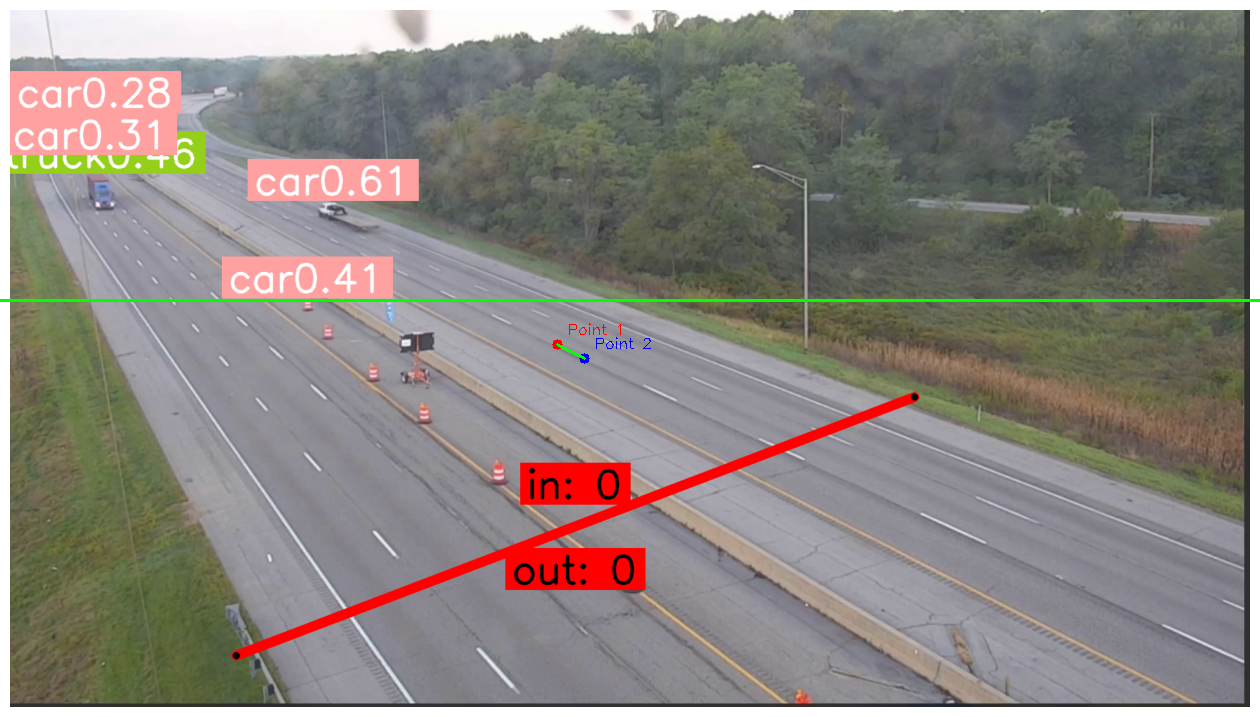

True

In [81]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Load the frame (ensure that the file is in the correct path or upload it to Colab)
frame = cv2.imread("/content/traffic.png")  # Adjust the path based on your Colab file structure

# Coordinates of the points (you can modify these)
point1 = (557, 344)
point2 = (584, 358)

# Horizon line
point3 = (0, 300)
point4 = (1280, 300)

# Measure the pixel distance between these two points
pixel_distance = np.linalg.norm(np.array(point2) - np.array(point1))

# Lane dashes are 10ft long
real_world_length_feet = 10

# Calculate pixel-to-feet ratio
pixel_to_feet_ratio = real_world_length_feet / pixel_distance
print(f"Pixel-to-feet ratio: {pixel_to_feet_ratio} feet/pixel")

# Draw the points on the image
cv2.circle(frame, point1, radius=5, color=(0, 0, 255), thickness=-1)  # Red point for point1
cv2.circle(frame, point2, radius=5, color=(255, 0, 0), thickness=-1)  # Blue point for point2

cv2.line(frame, point3, point4, color=(0, 255, 0), thickness=2)  # Green line

# Draw a line between the two points
cv2.line(frame, point1, point2, color=(0, 255, 0), thickness=2)  # Green line

# Annotate the points with text
cv2.putText(frame, 'Point 1', (point1[0] + 10, point1[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
cv2.putText(frame, 'Point 2', (point2[0] + 10, point2[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

# Display the image using cv2_imshow
cv2_imshow(frame)

# If you want to save the output image
cv2.imwrite("/content/output_image.png", frame)
